In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, columns, nan_as_category=True):        
    original_columns = df.columns
    
    df = pd.get_dummies(df, columns=columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
def read_data(path_to_sales, path_to_customers):
    sales_df = pd.read_csv(path_to_sales, sep='\t').reset_index(drop=True)
    sales_df.drop(columns='location', inplace=True)
    customers_df = pd.read_csv(path_to_customers, sep='\t')
    return sales_df, customers_df

In [4]:
#make features
def make_features(sales_df, customers_df, use_norm_price=True):
    
    norm_prices_dict = {}
    if use_norm_price:       
        norm_prices_dict = sales_df.groupby('sku_id')['price'].first().to_dict()
        sales_df['price'] = sales_df['price']/sales_df['sku_id'].map(norm_prices_dict)
        
    
    
    #this trick is faster than groupby diff approach up to 10-100 times on big datasets
    sales_df = sales_df.sort_values(['sku_id','ira','year', 'month'])

    sales_df['price_ratio'] = np.where((sales_df['sku_id']!=sales_df['sku_id'].shift()) | (sales_df['ira']!=sales_df['ira'].shift()),
                                      float('nan'),
                                      sales_df['price']/sales_df['price'].shift())
    sales_df['last_volume'] = np.where((sales_df['sku_id']!=sales_df['sku_id'].shift()) | (sales_df['ira']!=sales_df['ira'].shift()),
                                      float('nan'),
                                      sales_df['volume'].shift())
    sales_df['last_volume_diff'] = np.where((sales_df['sku_id']!=sales_df['sku_id'].shift()) | (sales_df['ira']!=sales_df['ira'].shift()),
                                      float('nan'),
                                      sales_df['last_volume'].diff())
    sales_df = sales_df.sort_index()
    
    
    
    customers_df['key'] = customers_df['year'].astype('str') + customers_df['month'].astype('str') +  customers_df['ira']
    sales_df['key'] = sales_df['year'].astype('str') + sales_df['month'].astype('str') +  sales_df['ira']
    
    customers_columns = []
    for i in customers_df.customers_type.unique():
        tmp_df = customers_df[customers_df.customers_type==i]
        tmp_dict = dict(zip(tmp_df.key,tmp_df.amount_of_customers))
        sales_df[f'amount_of_{i}_customers'] = sales_df['key'].map(tmp_dict)    
        customers_columns.append(f'amount_of_{i}_customers')

    cat_columns = ['ira', 'product_category', 'brand', 'sku_id', 'shape', 'with_alcohol', 'filling']
    ira = sales_df.ira
    sku_id = sales_df.sku_id
    sales_df, one_hot_columns = one_hot_encoder(sales_df, cat_columns)
    sales_df['ira'] =  ira
    sales_df['sku_id'] =  sku_id
    sales_df['total_customers'] = sales_df[customers_columns].sum(axis=1)
    features = ['item_per_bundle', 'month',  'price',  'total_customers'] + customers_columns + one_hot_columns
    
    return sales_df, features, norm_prices_dict
    


In [30]:
def predict_next_month(sales_df, customers_df, lgb_model, skip_no_price_items=False, use_norm_price=True):   
    last_year, last_month = sales_df[['year','month']].sort_values(by=['year','month']).tail(1).values[0]
    last_prices_dict = sales_df[(sales_df.year==last_year) & (sales_df.month==last_month)][['sku_id','ira','price']].set_index(['sku_id','ira']).to_dict()['price']
    sku_dict = {}
    for row in sales_df.itertuples():
        if row.sku_id not in sku_dict:
            sku_dict[row.sku_id] = (row.product_category, row.brand, row.item_per_bundle, row.shape, row.with_alcohol, row.filling)
            
    month_data = []
    if last_month != 12:
        month = last_month + 1
        year = last_year
    else:
        month = 1
        year = last_year + 1

    for sku in sales_df['sku_id'].unique():
        for ira in sales_df['ira'].unique():   
            if skip_no_price_items and (sku, ira) not in last_prices_dict:
                continue
            if (sku, ira) in last_prices_dict:
                price = last_prices_dict[(sku, ira)]
            else:
                price = float('nan')
            if sku in sku_dict:
                product_category, brand, item_per_bundle, shape, with_alcohol, filling = sku_dict[sku]
            else:
                product_category, brand,  shape, with_alcohol, filling = (float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'))
            volume = float('nan')
            month_data.append((year, month, ira, product_category, brand, sku, item_per_bundle, shape, with_alcohol, filling, volume, price))    
            
    month_df = pd.DataFrame(month_data, columns=['year', 'month', 'ira', 'product_category', 'brand', 'sku_id', 'item_per_bundle', 'shape', 'with_alcohol', 'filling', 'volume', 'price'])
    new_sales_df = pd.concat([sales_df, month_df]).reset_index(drop=True)
    new_sales_df, features, price_dict = make_features(new_sales_df, customers_df, use_norm_price=use_norm_price)
    new_sales_df_month = new_sales_df[(new_sales_df.year==year) & (new_sales_df.month==month)][features]
    month_df['volume'] = lgb_model.predict(new_sales_df_month)
    
    return month_df
    #break
    #[['sku_id','produc_category', 'brand',  'shape', 'with_alcohol', 'filling']]

In [37]:
def predict_n_months(sales_df, customers_df, n_month, lgb_model, skip_no_price_items=True, use_norm_price=True, check_tune=False, start_r=-15, stop_r=60):
    sales_df = sales_df.reset_index(drop=True)
    last_ind = sales_df.tail(1).index.values[0]
    print(last_ind)
    for i in range(n_month):        
        new_month = predict_next_month(sales_df, customers_df, lgb_model, skip_no_price_items=True, use_norm_price=use_norm_price)
        year, month = new_month[['year','month']].head(1).values[0]
        predicted_volume = new_month['volume'].sum()
        if not check_tune:
            print(f'Predicted volume for {year}-{month} = {predicted_volume:.0f}')
        sales_df = pd.concat([sales_df, new_month])     
        sales_df
        
    if check_tune:      
        print("")
        print("Check price tuning...")        
        new_sales_df = sales_df.reset_index(drop=True)        
        new_sales_df, features, price_dict = make_features(new_sales_df, customers_df, use_norm_price=use_norm_price)        
        new_sales_df = new_sales_df[new_sales_df.index > last_ind].reset_index(drop=True)
        
        for i in range(start_r, stop_r, 1):
            m = i/100
            vol, income = tune_price(lgb_model, new_sales_df, features, price_dict, multiplier=m)
            print(f'multiplier {m} volume = {vol:.0f}, income = {income:.3f}mln $') 
        

In [7]:
#for time series data it's important to split data to train and valid by time factor
def split_train_valid(sales_df, features, train_size=0.66):
    train_last_row_number = int(sales_df.shape[0] * train_size) + 1
    id_train = sales_df.index.values <= train_last_row_number
    id_test = sales_df.index.values > train_last_row_number
    df_train = sales_df.loc[id_train, features]
    df_valid = sales_df.loc[id_test, features]
    y_train = sales_df.loc[id_train, 'volume']
    y_valid = sales_df.loc[id_test, 'volume']
    return df_train, df_valid, y_train, y_valid, id_train, id_test

In [8]:
def train_model(df_train, df_valid, y_train, y_valid, params, features, ntree=300):
    
    train_data = lgb.Dataset(df_train, label=y_train.values)
    valid_data = lgb.Dataset(df_valid, label=y_valid.values)
    lgb_model = lgb.train(params, train_data, num_boost_round=ntree,
                            valid_sets = [train_data, valid_data], verbose_eval=10, 
                                  early_stopping_rounds = 10, feature_name=features) 

    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(df_valid)
    shap.dependence_plot('price', shap_values, df_valid)
    
    return lgb_model

In [9]:
def train_all_data_model(df_train, y_train, params, features, ntree=300):
    train_data = lgb.Dataset(df_train, label=y_train.values)  
    lgb_model = lgb.train(params, train_data, num_boost_round=ntree,
                            valid_sets = [train_data], verbose_eval=10, 
                                  feature_name=features) 
    
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(df_train)
    shap.dependence_plot('price', shap_values, df_train)
    
    return lgb_model

In [10]:

def score_model(lgb_model, df, ids, features):
    pred_df = df.loc[ids].reset_index(drop=True)
    tmp_df = pred_df[features]
    pred_df.loc[:,'pred_volume'] = lgb_model.predict(tmp_df, num_iteration=lgb_model.best_iteration)
    A = pred_df.groupby(['year','month'])['volume'].sum().values
    F = pred_df.groupby(['year','month'])['pred_volume'].sum().values
    MAPE = 100/len(A) * np.sum((np.abs(A-F))/((np.abs(A) + np.abs(F))/2))
    print(f'MAPE = {MAPE:.3f}%')
    

In [19]:
def tune_price(lgb_model, df, features, price_dict, multiplier=0.15):
    tmp_df = df[features].reset_index(drop=True)
    df = df.reset_index(drop=True)
    tmp_df['price'] = tmp_df['price'] * (1 + multiplier)
    volumes = lgb_model.predict(tmp_df, num_iteration=lgb_model.best_iteration)
    if len(price_dict) > 0:
        tmp_df['price'] = tmp_df['price'] * df['sku_id'].map(price_dict)
    tmp_df['price'] = tmp_df['price'].fillna(0)
    vol = np.sum(volumes)
    income = np.sum(volumes *  tmp_df['price'].values)/1000000
    return vol, income


In [14]:
def draw_volumes(lgb_model, sales_df, features, price_dict):
    volumes = []
    mults = []
    for i in range(-15,60,1):
        m = i/100    
        vol, income = tune_price(lgb_model, sales_df, features, price_dict, multiplier=m)
        mults.append(m)
        volumes.append(vol)
    plt.plot(mults, volumes)
    

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2371	valid_1's rmse: 1793.37
[20]	training's rmse: 1441.47	valid_1's rmse: 1316.53
[30]	training's rmse: 1124.57	valid_1's rmse: 1320.76
Early stopping, best iteration is:
[24]	training's rmse: 1274	valid_1's rmse: 1297.84


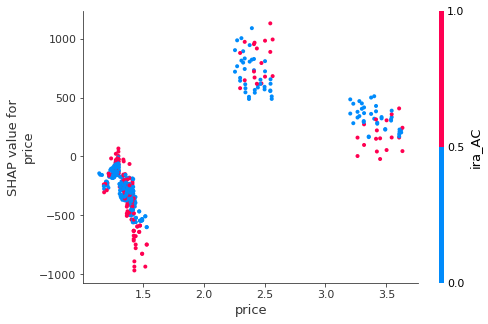

MAPE = 4.431%


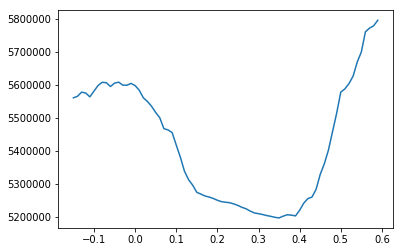

In [20]:
init_sales_df, customers_df = read_data('data/sales.tsv', 'data/customers.tsv')
sales_df, features, price_dict = make_features(init_sales_df, customers_df, use_norm_price=False)


params_lgb = {
        'bagging_freq': 1,
        'bagging_fraction': 1,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.5,
        'learning_rate': 0.1,
        'metric':'rmse',
        #'max_depth': 3,
        'min_data_in_leaf': 15,
        'tree_learner': 'serial',
        'objective': 'regression',
        'verbosity': -1
    }

df_train, df_valid, y_train, y_valid, id_train, id_valid = split_train_valid(sales_df, features, train_size=0.65)
lgb_model = train_model(df_train, df_valid, y_train, y_valid, params_lgb, features)
score_model(lgb_model, sales_df, id_valid, features)
draw_volumes(lgb_model, sales_df, features, price_dict)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2366.88	valid_1's rmse: 1793.73
[20]	training's rmse: 1442.95	valid_1's rmse: 1301.45
[30]	training's rmse: 1122.73	valid_1's rmse: 1289.01
Early stopping, best iteration is:
[25]	training's rmse: 1241.16	valid_1's rmse: 1274.23


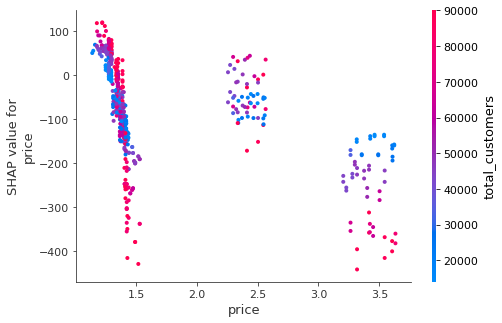

MAPE = 4.188%


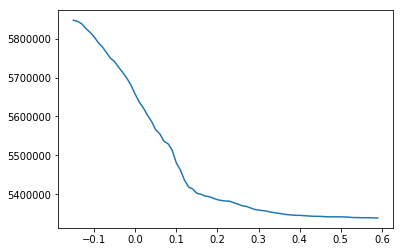

In [15]:
init_sales_df, customers_df = read_data('data/sales.tsv', 'data/customers.tsv')
sales_df, features, price_dict = make_features(init_sales_df, customers_df, use_norm_price=False)

monotone_constraints = [-1 if col == 'price' else 0 for col in features]
params_lgb = {
        'bagging_freq': 1,
        'bagging_fraction': 1,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.5,
        'learning_rate': 0.1,
        'metric':'rmse',
        #'max_depth': 3,
        'min_data_in_leaf': 15,
        'tree_learner': 'serial',
        'objective': 'regression',
        'monotone_constraints': monotone_constraints,
        'verbosity': -1
    }

df_train, df_valid, y_train, y_valid, id_train, id_valid = split_train_valid(sales_df, features, train_size=0.65)
lgb_model = train_model(df_train, df_valid, y_train, y_valid, params_lgb, features)
score_model(lgb_model, sales_df, id_valid, features)
draw_volumes(lgb_model, sales_df, features, price_dict)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2368.68	valid_1's rmse: 1780.02
[20]	training's rmse: 1431.8	valid_1's rmse: 1286.15
[30]	training's rmse: 1112.81	valid_1's rmse: 1274.55
Early stopping, best iteration is:
[25]	training's rmse: 1229.69	valid_1's rmse: 1254.87


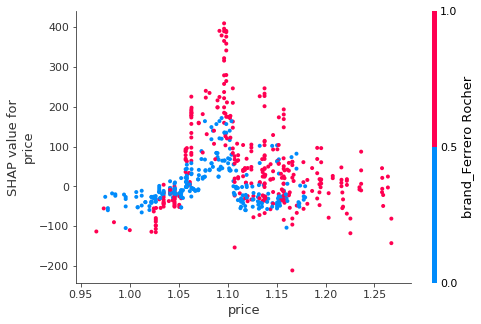

MAPE = 4.759%


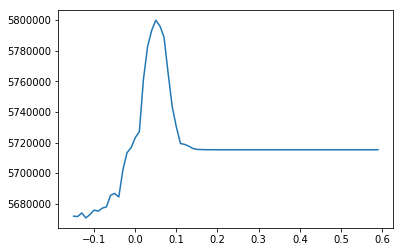

In [21]:
init_sales_df, customers_df = read_data('data/sales.tsv', 'data/customers.tsv')
sales_df, features, price_dict = make_features(init_sales_df, customers_df, use_norm_price=True)


params_lgb = {
        'bagging_freq': 1,
        'bagging_fraction': 1,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.5,
        'learning_rate': 0.1,
        'metric':'rmse',
        #'max_depth': 3,
        'min_data_in_leaf': 15,
        'tree_learner': 'serial',
        'objective': 'regression',
        'verbosity': -1
    }

df_train, df_valid, y_train, y_valid, id_train, id_valid = split_train_valid(sales_df, features, train_size=0.65)
lgb_model = train_model(df_train, df_valid, y_train, y_valid, params_lgb, features)
score_model(lgb_model, sales_df, id_valid, features)
draw_volumes(lgb_model, sales_df, features, price_dict)

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 2369.52	valid_1's rmse: 1787.19
[20]	training's rmse: 1444.04	valid_1's rmse: 1279.53
[30]	training's rmse: 1120.06	valid_1's rmse: 1249.11
Early stopping, best iteration is:
[25]	training's rmse: 1238.77	valid_1's rmse: 1239.08


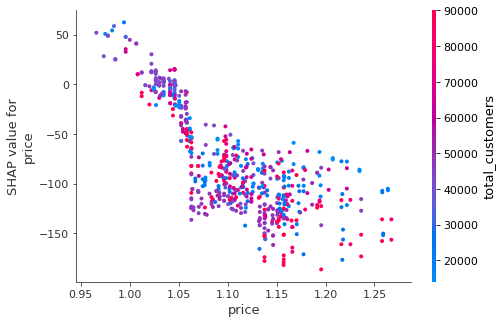

MAPE = 4.234%


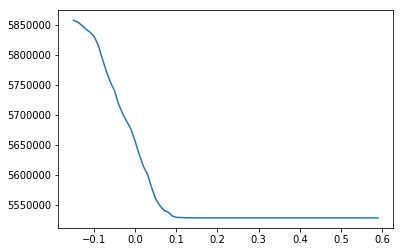

In [23]:
init_sales_df, customers_df = read_data('data/sales.tsv', 'data/customers.tsv')
sales_df, features, price_dict = make_features(init_sales_df, customers_df, use_norm_price=True)

monotone_constraints = [-1 if col == 'price' else 0 for col in features]
params_lgb = {
        'bagging_freq': 1,
        'bagging_fraction': 1,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.5,
        'learning_rate': 0.1,
        'metric':'rmse',
        #'max_depth': 3,
        'min_data_in_leaf': 15,
        'tree_learner': 'serial',
        'objective': 'regression',
        'monotone_constraints': monotone_constraints,
        'verbosity': -1
    }

df_train, df_valid, y_train, y_valid, id_train, id_valid = split_train_valid(sales_df, features, train_size=0.65)
lgb_model = train_model(df_train, df_valid, y_train, y_valid, params_lgb, features)
score_model(lgb_model, sales_df, id_valid, features)
draw_volumes(lgb_model, sales_df, features, price_dict)

[10]	training's rmse: 2326.22
[20]	training's rmse: 1387.39
[30]	training's rmse: 1075.9


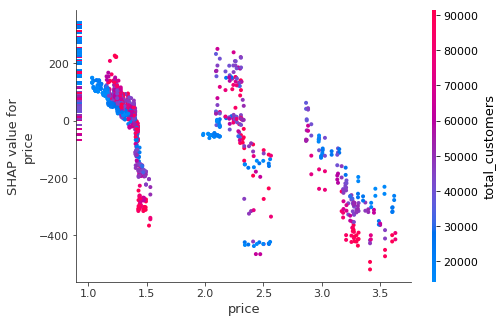

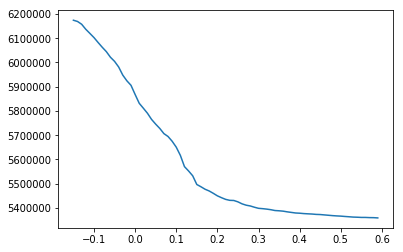

In [25]:
init_sales_df, customers_df = read_data('data/sales.tsv', 'data/customers.tsv')
sales_df, features, price_dict = make_features(init_sales_df, customers_df, use_norm_price=False)

params_lgb = {
        'bagging_freq': 1,
        'bagging_fraction': 1,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.5,
        'learning_rate': 0.1,
        'metric':'rmse',
        #'max_depth': 3,
        'min_data_in_leaf': 15,
        'tree_learner': 'serial',
        'objective': 'regression',
        'monotone_constraints': monotone_constraints,
        'verbosity': -1
    }
lgb_model_all = train_all_data_model(sales_df[features], sales_df['volume'], params_lgb, features, ntree=int(lgb_model.best_iteration * 1.5))
draw_volumes(lgb_model_all, sales_df, features, price_dict)

In [32]:
predict_n_months(init_sales_df, customers_df, 3, lgb_model_all, use_norm_price=False)

1728
Predicted volume for 2019-7 = 270753
Predicted volume for 2019-8 = 254058
Predicted volume for 2019-9 = 249381


In [36]:
predict_n_months(init_sales_df, customers_df, 3, lgb_model_all, check_tune=True, use_norm_price=False)

1728

Check price tuning...
(1915, 12)
(1915, 103)
(186, 103)
multiplier -0.15 volume = 828584, income = 1.311mln $
multiplier -0.14 volume = 828260, income = 1.326mln $
multiplier -0.13 volume = 824497, income = 1.337mln $
multiplier -0.12 volume = 815809, income = 1.339mln $
multiplier -0.11 volume = 815098, income = 1.354mln $
multiplier -0.1 volume = 813078, income = 1.363mln $
multiplier -0.09 volume = 811652, income = 1.375mln $
multiplier -0.08 volume = 809700, income = 1.387mln $
multiplier -0.07 volume = 800457, income = 1.388mln $
multiplier -0.06 volume = 792707, income = 1.391mln $
multiplier -0.05 volume = 788177, income = 1.395mln $
multiplier -0.04 volume = 786984, income = 1.408mln $
multiplier -0.03 volume = 781526, income = 1.410mln $
multiplier -0.02 volume = 778338, income = 1.419mln $
multiplier -0.01 volume = 778120, income = 1.433mln $
multiplier 0.0 volume = 774192, income = 1.438mln $
multiplier 0.01 volume = 772568, income = 1.450mln $
multiplier 0.02 volume =